Random Forest Models - unfilled

J - This notebook contains random forest models on unfilled data. There are four tagret variables - percentage ks2 expectations, percentage ks4 expectations, percentage substance misuse and percentage convictions. All of these are modelled individually one after the other.



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
!pip install imbalanced-learn
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from scipy.stats import randint
from sklearn.tree import export_graphviz
import graphviz
from IPython.display import Image

Reading in data

In [ ]:
data = pd.read_csv("final_data.csv")
data['la_name'] = pd.Categorical(data['la_name'])
data['reporting_year'] = data['reporting_year'].astype(int)
data.head()

,Unnamed: 0,la_code,reporting_year,academic_year,region_code,region_name,la_name,pt_ks2_expectations,pt_ks4_expectations,avg_p8score,...,pt_ks2_expectations_filled,pt_ks4_expectations_filled,avg_p8score_filled,per_child_spend,cla_budget_filled,ofsted_overall_filled,ofsted_leaders_filled,ofsted_care_filled,ofsted_help_protection_filled,budget_per_child
0,729,E09000002,2018,201718.0,E13000002,Outer London,Barking and Dagenham,43.0,NaN,-1.12,...,43.000000,26.040000,-1.120000,51.779951,21178.0,2.0,2.0,2.0,2.0,51.779951
1,580,E09000002,2019,201819.0,E13000002,Outer London,Barking and Dagenham,59.0,28.6,-0.74,...,59.000000,28.600000,-0.740000,48.355072,20019.0,2.0,2.0,2.0,2.0,48.355072
2,431,E09000002,2020,201920.0,E13000002,Outer London,Barking and Dagenham,NaN,37.9,NaN,...,48.777778,37.900000,-1.315192,48.189055,19372.0,2.0,2.0,2.0,2.0,48.189055
3,280,E09000002,2021,202021.0,E13000002,Outer London,Barking and Dagenham,NaN,30.8,NaN,...,48.777778,30.800000,-1.315192,47.056266,18399.0,2.0,2.0,2.0,2.0,47.056266
4,130,E09000002,2022,202122.0,E13000002,Outer London,Barking and Dagenham,50.0,NaN,-1.29,...,50.000000,31.557143,-1.290000,50.869249,21009.0,2.0,2.0,2.0,2.0,50.869249


Scaling and checking categorical variables

In [ ]:
#create scaled version of data, all measurements should be on 0-1
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data_scaled = data.copy()
scalable_columns = ['number_in_care_filled', 'budget_per_child', 'pt_ks2_expectations', 'pt_ks4_expectations', 'avg_p8score', 'pt_convictions', 'pt_placed_inside_la', 'pt_substance', 'pt_private_provis', 'pt_3_more_placemts', 'pt_convictions_filled', 'pt_placed_inside_la_filled', 'pt_substance_filled', 'pt_private_provis_filled', 'pt_3_more_placemts_filled', 'pt_ks2_expectations_filled', 'pt_ks4_expectations_filled', 'avg_p8score_filled', 'per_child_spend']
data_scaled[scalable_columns] = scaler.fit_transform(data_scaled[scalable_columns])
print(data_scaled[scalable_columns].describe())


#check categorical variables are set as categories

data_scaled['la_name'] = data_scaled['la_name'].astype('category')
data_scaled['la_code'] = data_scaled['la_code'].astype('category')
data_scaled['ofsted_overall'] = data_scaled['ofsted_overall'].astype('category')
data_scaled['ofsted_leaders'] = data_scaled['ofsted_leaders'].astype('category')
data_scaled['ofsted_care'] = data_scaled['ofsted_care'].astype('category')
data_scaled['ofsted_help_protection'] = data_scaled['ofsted_help_protection'].astype('category')


#separate out filled and unfilled data

#will need to ensure we include budget_per_child filled once available
filled_cols = ['number_in_care_filled', 'region_name', 'ofsted_leaders_filled', 'per_child_spend','ofsted_care_filled', 'ofsted_help_protection_filled','la_name', 'reporting_year','ofsted_overall_filled' ,'pt_convictions_filled', 'pt_placed_inside_la_filled', 'pt_substance_filled', 'pt_private_provis_filled', 'pt_3_more_placemts_filled', 'pt_ks2_expectations_filled', 'pt_ks4_expectations_filled', 'avg_p8score_filled']
original_cols = ['number_in_care', 'region_name','la_name', 'reporting_year', 'ofsted_overall','ofsted_care', 'ofsted_help_protection', 'ofsted_leaders', 'budget_per_child', 'pt_ks2_expectations', 'pt_ks4_expectations', 'avg_p8score', 'pt_convictions', 'pt_placed_inside_la', 'pt_substance', 'pt_private_provis', 'pt_3_more_placemts']
filleddata = data_scaled[filled_cols]
originaldata = data_scaled[original_cols]

originaldata.reset_index(drop=True, inplace=True)
filleddata.reset_index(drop = True, inplace = True)

       number_in_care_filled  budget_per_child  pt_ks2_expectations  \
count             750.000000        750.000000           229.000000   
mean                0.246364          0.352640             0.338638   
std                 0.165839          0.126835             0.173686   
min                 0.000000          0.000000             0.000000   
25%                 0.140736          0.260079             0.210526   
50%                 0.202375          0.339699             0.315789   
75%                 0.303919          0.425106             0.438596   
max                 1.000000          1.000000             1.000000   

       pt_ks4_expectations  avg_p8score  pt_convictions  pt_placed_inside_la  \
count           469.000000   431.000000      482.000000           747.000000   
mean              0.449708     0.605523        0.237621             0.613078   
std               0.146512     0.138589        0.156554             0.189203   
min               0.000000     0.000000 

**1) Target - pt_ks2_expectations filled**

Creating Data Frame, setting target, splitting data

In [ ]:
df = pd.DataFrame(originaldata, columns=['number_in_care', 'region_name','la_name', 'reporting_year', 'ofsted_overall','ofsted_care', 'ofsted_help_protection', 'ofsted_leaders', 'budget_per_child', 'pt_ks2_expectations', 'pt_ks4_expectations', 'avg_p8score', 'pt_convictions', 'pt_placed_inside_la', 'pt_substance', 'pt_private_provis', 'pt_3_more_placemts'])

In [ ]:
df['target'] = originaldata['pt_ks2_expectations']

In [ ]:
train, test = train_test_split(df, test_size=0.25, random_state=7)
X_train = train[['pt_placed_inside_la', 'pt_private_provis', 'pt_3_more_placemts', 'budget_per_child', 'reporting_year', 'number_in_care', 'ofsted_overall', 'ofsted_leaders', 'ofsted_help_protection', 'ofsted_care']]
X_test = test[['pt_placed_inside_la', 'pt_private_provis', 'pt_3_more_placemts', 'budget_per_child', 'reporting_year', 'number_in_care', 'ofsted_overall', 'ofsted_leaders', 'ofsted_help_protection', 'ofsted_care']]
y_train = train['target']
y_test = test['target']

In [ ]:
reg = RandomForestRegressor()
trainmask = X_train.pt_placed_inside_la.notnull() & X_train.pt_private_provis.notnull() & X_train.pt_3_more_placemts.notnull() & X_train.budget_per_child.notnull() &X_train.reporting_year.notnull() & X_train.number_in_care.notnull() & X_train.ofsted_overall.notnull() & X_train.ofsted_care.notnull() &X_train.ofsted_leaders.notnull() & X_train.ofsted_help_protection.notnull() & y_train.notnull()
reg.fit(X_train[trainmask], y_train[trainmask])

RandomForestRegressor()

In [ ]:
y_pred_train = reg.predict(X_train[trainmask])
mean_absolute_error(y_train[trainmask], y_pred_train)

0.04650683089158724

In [ ]:
testmask = X_test.pt_placed_inside_la.notnull() & X_test.pt_private_provis.notnull() & X_test.pt_3_more_placemts.notnull() & X_test.budget_per_child.notnull() &X_test.reporting_year.notnull() & X_test.number_in_care.notnull() & X_test.ofsted_overall.notnull() & X_test.ofsted_care.notnull() &X_test.ofsted_leaders.notnull() & X_test.ofsted_help_protection.notnull() & y_test.notnull()
reg.fit(X_test[testmask], y_test[testmask])

RandomForestRegressor()

In [ ]:
y_pred_test = reg.predict(X_test[testmask])
mean_absolute_error(y_test[testmask], y_pred_test)

0.05065162907268171

In [ ]:
input_features = ['pt_placed_inside_la', 'pt_private_provis', 'pt_3_more_placemts', 'budget_per_child', 'reporting_year', 'number_in_care', 'ofsted_overall', 'ofsted_leaders', 'ofsted_help_protection', 'ofsted_care']

RandomizedSearchCV

In [ ]:
param_distributions = {
    'n_estimators': randint(100, 1000),
    'max_features': ['auto', 'sqrt'],
    'max_depth': randint(10, 100),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 50),
    'bootstrap': [True, False]
}

rf_regressor = RandomForestRegressor()

rnd_search_cv = RandomizedSearchCV(estimator=rf_regressor, param_distributions=param_distributions,
                                   n_iter=100,
                                   cv=5, scoring='neg_mean_squared_error',
                                   random_state=42, n_jobs=-1)

rnd_search_cv.fit(X_train[trainmask], y_train[trainmask])

print("Best parameters found:", rnd_search_cv.best_params_)


KeyboardInterrupt: 

First round of GridSearchCV

In [ ]:
param_grid_1 = {
    'bootstrap': [True],
    'max_depth': [50, 56, 62],
    'max_features': ['sqrt'],
    'min_samples_leaf': [2, 3, 4],
    'min_samples_split': [2, 3, 4],
    'n_estimators': [84, 104, 124]
}


model = RandomForestRegressor(random_state=42)

grid_search_1 = GridSearchCV(estimator=model, param_grid=param_grid_1, cv=5,
                             scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)

grid_search_1.fit(X_train[trainmask], y_train[trainmask])

print("Best parameters from round 1:", grid_search_1.best_params_)


Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best parameters from round 1: {'bootstrap': True, 'max_depth': 50, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 84}


In [ ]:
param_grid_2 = {
    'bootstrap': [True],
    'max_depth': [48, 50, 52],
    'max_features': ['sqrt'],
    'min_samples_leaf': [3, 4],
    'min_samples_split': [2],
    'n_estimators': [74, 84, 94]
},

model = RandomForestRegressor(random_state=42)

grid_search_2 = GridSearchCV(estimator=model, param_grid=param_grid_2, cv=5,
                             scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)

grid_search_2.fit(X_train[trainmask], y_train[trainmask])

print("Best parameters from round 2:", grid_search_2.best_params_)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best parameters from round 2: {'bootstrap': True, 'max_depth': 48, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 74}


Fitting model to final parameters

In [ ]:
optimized_rf = RandomForestRegressor(
    bootstrap=True,
    max_depth=48,
    max_features='sqrt',
    min_samples_leaf=3,
    min_samples_split=2,
    n_estimators=74,
    random_state=42
)

optimized_rf.fit(X_train[trainmask], y_train[trainmask])

RandomForestRegressor(max_depth=48, max_features='sqrt', min_samples_leaf=3,
                      n_estimators=74, random_state=42)

MSE, RMSE, standardised RMSE, feature importances

In [ ]:
y_pred = optimized_rf.predict(X_test[testmask])

mse = mean_squared_error(y_test[testmask], y_pred)*10000
print("Mean Absolute Error:", mean_absolute_error(y_test[testmask], y_pred))
print("Mean Squared Error:", mse)

Mean Absolute Error: 0.08029473300968183
Mean Squared Error: 113.33455686095091


In [ ]:
rmse = np.sqrt(mse)
standardised_rmse = rmse / np.std(y_test[testmask]*100)
print("RMSE:", rmse)
print("standardised RMSE", standardised_rmse)

RMSE: 10.645870413496066
standardised RMSE 0.8237490039250296


In [ ]:
feature_importances = optimized_rf.feature_importances_
features_and_importances = list(zip(input_features, feature_importances))

feature_importances = pd.Series(optimized_rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

print(feature_importances)

sorted_indices = np.argsort(feature_importances)[::-1]

number_in_care            0.341477
budget_per_child          0.154987
pt_placed_inside_la       0.152388
pt_private_provis         0.102806
reporting_year            0.076754
ofsted_overall            0.050382
pt_3_more_placemts        0.046753
ofsted_care               0.030069
ofsted_help_protection    0.026804
ofsted_leaders            0.017580
dtype: float64


**2) Target - pt_ks4_expectations**

In [ ]:
df['target'] = originaldata['pt_ks4_expectations']

In [ ]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.25, random_state=7)
X_train = train[['pt_placed_inside_la', 'pt_private_provis', 'pt_3_more_placemts', 'budget_per_child', 'reporting_year', 'number_in_care', 'ofsted_overall', 'ofsted_leaders', 'ofsted_help_protection', 'ofsted_care']]
X_test = test[['pt_placed_inside_la', 'pt_private_provis', 'pt_3_more_placemts', 'budget_per_child', 'reporting_year', 'number_in_care', 'ofsted_overall', 'ofsted_leaders', 'ofsted_help_protection', 'ofsted_care']]
y_train = train['target']
y_test = test['target']

In [ ]:
reg = RandomForestRegressor()
trainmask = X_train.pt_placed_inside_la.notnull() & X_train.pt_private_provis.notnull() & X_train.pt_3_more_placemts.notnull() & X_train.budget_per_child.notnull() &X_train.reporting_year.notnull() & X_train.number_in_care.notnull() & X_train.ofsted_overall.notnull() & X_train.ofsted_care.notnull() &X_train.ofsted_leaders.notnull() & X_train.ofsted_help_protection.notnull() & y_train.notnull()
reg.fit(X_train[trainmask], y_train[trainmask])

RandomForestRegressor()

In [ ]:
y_pred_train = reg.predict(X_train[trainmask])
mean_absolute_error(y_train[trainmask], y_pred_train)

0.11272816489529566

In [ ]:
testmask = X_test.pt_placed_inside_la.notnull() & X_test.pt_private_provis.notnull() & X_test.pt_3_more_placemts.notnull() & X_test.budget_per_child.notnull() &X_test.reporting_year.notnull() & X_test.number_in_care.notnull() & X_test.ofsted_overall.notnull() & X_test.ofsted_care.notnull() &X_test.ofsted_leaders.notnull() & X_test.ofsted_help_protection.notnull() & y_test.notnull()
reg.fit(X_test[testmask], y_test[testmask])

RandomForestRegressor()

In [ ]:
y_pred_test = reg.predict(X_test[testmask])
mean_absolute_error(y_test[testmask], y_pred_test)

0.03135688723064033

RandomizedSearchCV

In [ ]:
param_distributions = {
    'n_estimators': randint(100, 1000),
    'max_features': ['auto', 'sqrt'],
    'max_depth': randint(10, 100),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 50),
    'bootstrap': [True, False]
}

rf_regressor = RandomForestRegressor()

rnd_search_cv = RandomizedSearchCV(estimator=rf_regressor, param_distributions=param_distributions,
                                   n_iter=100,
                                   cv=5, scoring='neg_mean_squared_error',
                                   random_state=42, n_jobs=-1)

rnd_search_cv.fit(X_train[trainmask], y_train[trainmask])

print("Best parameters found:", rnd_search_cv.best_params_)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


Best parameters found: {'bootstrap': False, 'max_depth': 22, 'max_features': 'auto', 'min_samples_leaf': 19, 'min_samples_split': 18, 'n_estimators': 711}


First round of GridSearchCV

In [ ]:
param_grid_1 = {
    'bootstrap': [False],
    'max_depth': [16, 22, 28],
    'max_features': [1.0],
    'min_samples_leaf': [18, 19, 20],
    'min_samples_split': [17, 18, 19],
    'n_estimators': [700, 711, 722]
}


model = RandomForestRegressor(random_state=42)

grid_search_1 = GridSearchCV(estimator=model, param_grid=param_grid_1, cv=5,
                             scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)

grid_search_1.fit(X_train[trainmask], y_train[trainmask])

print("Best parameters from round 1:", grid_search_1.best_params_)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best parameters from round 1: {'bootstrap': False, 'max_depth': 16, 'max_features': 1.0, 'min_samples_leaf': 19, 'min_samples_split': 17, 'n_estimators': 700}


Second round of GridSearchCV

In [ ]:
param_grid_2 = {
    'bootstrap': [False],
    'max_depth': [14, 16, 18],
    'max_features': [1.0],
    'min_samples_leaf': [18, 19, 20],
    'min_samples_split': [16, 17, 18],
    'n_estimators': [690, 700, 710]
},

model = RandomForestRegressor(random_state=42)

grid_search_2 = GridSearchCV(estimator=model, param_grid=param_grid_2, cv=5,
                             scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)

grid_search_2.fit(X_train[trainmask], y_train[trainmask])

print("Best parameters from round 2:", grid_search_2.best_params_)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best parameters from round 2: {'bootstrap': False, 'max_depth': 14, 'max_features': 1.0, 'min_samples_leaf': 19, 'min_samples_split': 16, 'n_estimators': 690}


Fitting model to final parameters

In [ ]:
optimized_rf = RandomForestRegressor(
    bootstrap=False,
    max_depth=14,
    max_features=1.0,
    min_samples_leaf=19,
    min_samples_split=16,
    n_estimators=690,
    random_state=42
)

optimized_rf.fit(X_train[trainmask], y_train[trainmask])

RandomForestRegressor(bootstrap=False, max_depth=14, min_samples_leaf=19,
                      min_samples_split=16, n_estimators=690, random_state=42)

MSE, RMSE, standardised MSE and feature importances

In [ ]:
y_pred = optimized_rf.predict(X_test[testmask])

mse = mean_squared_error(y_test[testmask], y_pred)*10000
print("Mean Absolute Error:", mean_absolute_error(y_test[testmask], y_pred))
print("Mean Squared Error:", mse)

Mean Absolute Error: 0.07993223178253174
Mean Squared Error: 94.49432546605655


In [ ]:
rmse = np.sqrt(mse)
standardised_rmse = rmse / np.std(y_test[testmask]*100)
print("RMSE:", rmse)
print("standardised RMSE", standardised_rmse)

RMSE: 9.720819176697844
standardised RMSE 0.9604816934357575


In [ ]:
feature_importances = optimized_rf.feature_importances_
features_and_importances = list(zip(input_features, feature_importances))

feature_importances = pd.Series(optimized_rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

print(feature_importances)

sorted_indices = np.argsort(feature_importances)[::-1]

number_in_care            0.750993
ofsted_leaders            0.249007
pt_placed_inside_la       0.000000
pt_private_provis         0.000000
pt_3_more_placemts        0.000000
budget_per_child          0.000000
reporting_year            0.000000
ofsted_overall            0.000000
ofsted_help_protection    0.000000
ofsted_care               0.000000
dtype: float64


**3) Substance misuse**

In [ ]:
df['target'] = originaldata['pt_substance']

In [ ]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.25, random_state=7)
X_train = train[['pt_placed_inside_la', 'pt_private_provis', 'pt_3_more_placemts', 'budget_per_child', 'reporting_year', 'number_in_care', 'ofsted_overall', 'ofsted_leaders', 'ofsted_help_protection', 'ofsted_care']]
X_test = test[['pt_placed_inside_la', 'pt_private_provis', 'pt_3_more_placemts', 'budget_per_child', 'reporting_year', 'number_in_care', 'ofsted_overall', 'ofsted_leaders', 'ofsted_help_protection', 'ofsted_care']]
y_train = train['target']
y_test = test['target']

In [ ]:
from sklearn.ensemble import RandomForestRegressor
reg = RandomForestRegressor()
trainmask = X_train.pt_placed_inside_la.notnull() & X_train.pt_private_provis.notnull() & X_train.pt_3_more_placemts.notnull() & X_train.budget_per_child.notnull() &X_train.reporting_year.notnull() & X_train.number_in_care.notnull() & X_train.ofsted_overall.notnull() & X_train.ofsted_care.notnull() &X_train.ofsted_leaders.notnull() & X_train.ofsted_help_protection.notnull() & y_train.notnull()
reg.fit(X_train[trainmask], y_train[trainmask])

RandomForestRegressor()

In [ ]:
from sklearn.metrics import mean_absolute_error
y_pred_train = reg.predict(X_train[trainmask])
mean_absolute_error(y_train[trainmask], y_pred_train)

0.03249003262051465

In [ ]:
testmask = X_test.pt_placed_inside_la.notnull() & X_test.pt_private_provis.notnull() & X_test.pt_3_more_placemts.notnull() & X_test.budget_per_child.notnull() &X_test.reporting_year.notnull() & X_test.number_in_care.notnull() & X_test.ofsted_overall.notnull() & X_test.ofsted_care.notnull() &X_test.ofsted_leaders.notnull() & X_test.ofsted_help_protection.notnull() & y_test.notnull()
reg.fit(X_test[testmask], y_test[testmask])

RandomForestRegressor()

In [ ]:
y_pred_test = reg.predict(X_test[testmask])
mean_absolute_error(y_test[testmask], y_pred_test)

0.02396654719235364

RandomizedSearchCV

In [ ]:
param_distributions = {
    'n_estimators': randint(100, 1000),
    'max_features': ['auto', 'sqrt'],
    'max_depth': randint(10, 100),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 50),
    'bootstrap': [True, False]
}

rf_regressor = RandomForestRegressor()

rnd_search_cv = RandomizedSearchCV(estimator=rf_regressor, param_distributions=param_distributions,
                                   n_iter=100,
                                   cv=5, scoring='neg_mean_squared_error',
                                   random_state=42, n_jobs=-1)

rnd_search_cv.fit(X_train[trainmask], y_train[trainmask])

print("Best parameters found:", rnd_search_cv.best_params_)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


Best parameters found: {'bootstrap': False, 'max_depth': 39, 'max_features': 'auto', 'min_samples_leaf': 17, 'min_samples_split': 6, 'n_estimators': 573}


First round of GridSearchCV

In [ ]:
param_grid_1 = {
    'bootstrap': [False],
    'max_depth': [33, 39, 45],
    'max_features': [1.0],
    'min_samples_leaf': [15, 17, 19],
    'min_samples_split': [4, 6, 8],
    'n_estimators': [560, 573, 590]
}


model = RandomForestRegressor(random_state=42)

grid_search_1 = GridSearchCV(estimator=model, param_grid=param_grid_1, cv=5,
                             scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)

grid_search_1.fit(X_train[trainmask], y_train[trainmask])

print("Best parameters from round 1:", grid_search_1.best_params_)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best parameters from round 1: {'bootstrap': False, 'max_depth': 33, 'max_features': 1.0, 'min_samples_leaf': 15, 'min_samples_split': 4, 'n_estimators': 590}


Second round of GridSearchCV

In [ ]:
param_grid_2 = {
    'bootstrap': [False],
    'max_depth': [30, 33, 36],
    'max_features': [1.0],
    'min_samples_leaf': [14, 15, 16],
    'min_samples_split': [3, 4, 5],
    'n_estimators': [580, 590, 600]
},

model = RandomForestRegressor(random_state=42)

grid_search_2 = GridSearchCV(estimator=model, param_grid=param_grid_2, cv=5,
                             scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)

grid_search_2.fit(X_train[trainmask], y_train[trainmask])

print("Best parameters from round 2:", grid_search_2.best_params_)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best parameters from round 2: {'bootstrap': False, 'max_depth': 30, 'max_features': 1.0, 'min_samples_leaf': 16, 'min_samples_split': 3, 'n_estimators': 590}


Final model with best hyperparameters

In [ ]:
optimized_rf = RandomForestRegressor(
    bootstrap=False,
    max_depth=30,
    max_features=1.0,
    min_samples_leaf=16,
    min_samples_split=3,
    n_estimators=590,
    random_state=42
)

optimized_rf.fit(X_train[trainmask], y_train[trainmask])

RandomForestRegressor(bootstrap=False, max_depth=30, min_samples_leaf=16,
                      min_samples_split=3, n_estimators=590, random_state=42)

MSE, RMSE, standardised MSE, feature importances

In [ ]:
y_pred = optimized_rf.predict(X_test[testmask])

mse = mean_squared_error(y_test[testmask], y_pred)*10000
print("Mean Absolute Error:", mean_absolute_error(y_test[testmask], y_pred))
print("Mean Squared Error:", mse)

Mean Absolute Error: 0.08992822276587843
Mean Squared Error: 138.44632036245997


In [ ]:
rmse = np.sqrt(mse)
standardised_rmse = rmse / np.std(y_test[testmask]*100)
print("RMSE:", rmse)
print("standardised RMSE", standardised_rmse)

RMSE: 11.766321445654116
standardised RMSE 1.0605027348727758


In [ ]:
feature_importances = optimized_rf.feature_importances_
features_and_importances = list(zip(input_features, feature_importances))

feature_importances = pd.Series(optimized_rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

print(feature_importances)

sorted_indices = np.argsort(feature_importances)[::-1]

pt_private_provis         0.748309
pt_3_more_placemts        0.216385
number_in_care            0.035306
pt_placed_inside_la       0.000000
budget_per_child          0.000000
reporting_year            0.000000
ofsted_overall            0.000000
ofsted_leaders            0.000000
ofsted_help_protection    0.000000
ofsted_care               0.000000
dtype: float64


**4) Target - convictions**

In [ ]:
df['target'] = originaldata['pt_convictions']

In [ ]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.25, random_state = 7)
X_train = train[['pt_placed_inside_la', 'pt_private_provis', 'pt_3_more_placemts', 'budget_per_child', 'reporting_year', 'number_in_care', 'ofsted_overall', 'ofsted_leaders', 'ofsted_help_protection', 'ofsted_care']]
X_test = test[['pt_placed_inside_la', 'pt_private_provis', 'pt_3_more_placemts', 'budget_per_child', 'reporting_year', 'number_in_care', 'ofsted_overall', 'ofsted_leaders', 'ofsted_help_protection', 'ofsted_care']]
y_train = train['target']
y_test = test['target']

In [ ]:
from sklearn.ensemble import RandomForestRegressor
reg = RandomForestRegressor()
trainmask = X_train.pt_placed_inside_la.notnull() & X_train.pt_private_provis.notnull() & X_train.pt_3_more_placemts.notnull() & X_train.budget_per_child.notnull() &X_train.reporting_year.notnull() & X_train.number_in_care.notnull() & X_train.ofsted_overall.notnull() & X_train.ofsted_care.notnull() &X_train.ofsted_leaders.notnull() & X_train.ofsted_help_protection.notnull() & y_train.notnull()
reg.fit(X_train[trainmask], y_train[trainmask])

RandomForestRegressor()

In [ ]:
from sklearn.metrics import mean_absolute_error
y_pred_train = reg.predict(X_train[trainmask])
mean_absolute_error(y_train[trainmask], y_pred_train)

0.04305882352941184

In [ ]:
testmask = X_test.pt_placed_inside_la.notnull() & X_test.pt_private_provis.notnull() & X_test.pt_3_more_placemts.notnull() & X_test.budget_per_child.notnull() &X_test.reporting_year.notnull() & X_test.number_in_care.notnull() & X_test.ofsted_overall.notnull() & X_test.ofsted_care.notnull() &X_test.ofsted_leaders.notnull() & X_test.ofsted_help_protection.notnull() & y_test.notnull()
reg.fit(X_test[testmask], y_test[testmask])

RandomForestRegressor()

In [ ]:
y_pred_test = reg.predict(X_test[testmask])
mean_absolute_error(y_test[testmask], y_pred_test)

0.033684210526315726

RandomisedSearchCV

In [ ]:
param_distributions = {
    'n_estimators': randint(100, 1000),
    'max_features': ['auto', 'sqrt'],
    'max_depth': randint(10, 100),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 50),
    'bootstrap': [True, False]
}

rf_regressor = RandomForestRegressor()

rnd_search_cv = RandomizedSearchCV(estimator=rf_regressor, param_distributions=param_distributions,
                                   n_iter=100,
                                   cv=5, scoring='neg_mean_squared_error',
                                   random_state=42, n_jobs=-1)

rnd_search_cv.fit(X_train[trainmask], y_train[trainmask])

print("Best parameters found:", rnd_search_cv.best_params_)

Best parameters found: {'bootstrap': False, 'max_depth': 98, 'max_features': 'sqrt', 'min_samples_leaf': 14, 'min_samples_split': 19, 'n_estimators': 876}


In [ ]:
param_grid_1 = {
    'bootstrap': [False],
    'max_depth': [94, 98, 102],
    'max_features': ['sqrt'],
    'min_samples_leaf': [12, 14, 16],
    'min_samples_split': [17, 19, 21],
    'n_estimators': [860, 876, 890]
}


model = RandomForestRegressor(random_state=42)

grid_search_1 = GridSearchCV(estimator=model, param_grid=param_grid_1, cv=5,
                             scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)

grid_search_1.fit(X_train[trainmask], y_train[trainmask])

print("Best parameters from round 1:", grid_search_1.best_params_)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best parameters from round 1: {'bootstrap': False, 'max_depth': 94, 'max_features': 'sqrt', 'min_samples_leaf': 14, 'min_samples_split': 17, 'n_estimators': 860}


In [ ]:
param_grid_2 = {
    'bootstrap': [False],
    'max_depth': [92, 94, 96],
    'max_features': ['sqrt'],
    'min_samples_leaf': [13, 14, 15],
    'min_samples_split': [16, 17, 18],
    'n_estimators': [850, 860, 870]
},

model = RandomForestRegressor(random_state=42)

grid_search_2 = GridSearchCV(estimator=model, param_grid=param_grid_2, cv=5,
                             scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)

grid_search_2.fit(X_train[trainmask], y_train[trainmask])

print("Best parameters from round 2:", grid_search_2.best_params_)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best parameters from round 2: {'bootstrap': False, 'max_depth': 92, 'max_features': 'sqrt', 'min_samples_leaf': 14, 'min_samples_split': 16, 'n_estimators': 850}


In [ ]:
optimized_rf = RandomForestRegressor(
    bootstrap=False,
    max_depth=92,
    max_features='sqrt',
    min_samples_leaf=14,
    min_samples_split=16,
    n_estimators=850,
    random_state=42
)

optimized_rf.fit(X_train[trainmask], y_train[trainmask])

RandomForestRegressor(bootstrap=False, max_depth=92, max_features='sqrt',
                      min_samples_leaf=14, min_samples_split=16,
                      n_estimators=850, random_state=42)

In [ ]:
y_pred = optimized_rf.predict(X_test[testmask])

mse = mean_squared_error(y_test[testmask], y_pred)*10000
print("Mean Absolute Error:", mean_absolute_error(y_test[testmask], y_pred))
print("Mean Squared Error:", mse)

Mean Absolute Error: 0.08231827952545653
Mean Squared Error: 124.85069617426521


In [ ]:
rmse = np.sqrt(mse)
standardised_rmse = rmse / np.std(y_test[testmask]*100)
print("RMSE:", rmse)
print("standardised RMSE", standardised_rmse)

RMSE: 11.173660822410229
standardised RMSE 0.985575944419243


In [ ]:
feature_importances = optimized_rf.feature_importances_
features_and_importances = list(zip(input_features, feature_importances))

feature_importances = pd.Series(optimized_rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

print(feature_importances)

sorted_indices = np.argsort(feature_importances)[::-1]

pt_private_provis         0.293680
pt_placed_inside_la       0.170641
pt_3_more_placemts        0.165248
budget_per_child          0.134839
reporting_year            0.091455
number_in_care            0.073458
ofsted_help_protection    0.046574
ofsted_leaders            0.013719
ofsted_overall            0.009867
ofsted_care               0.000519
dtype: float64


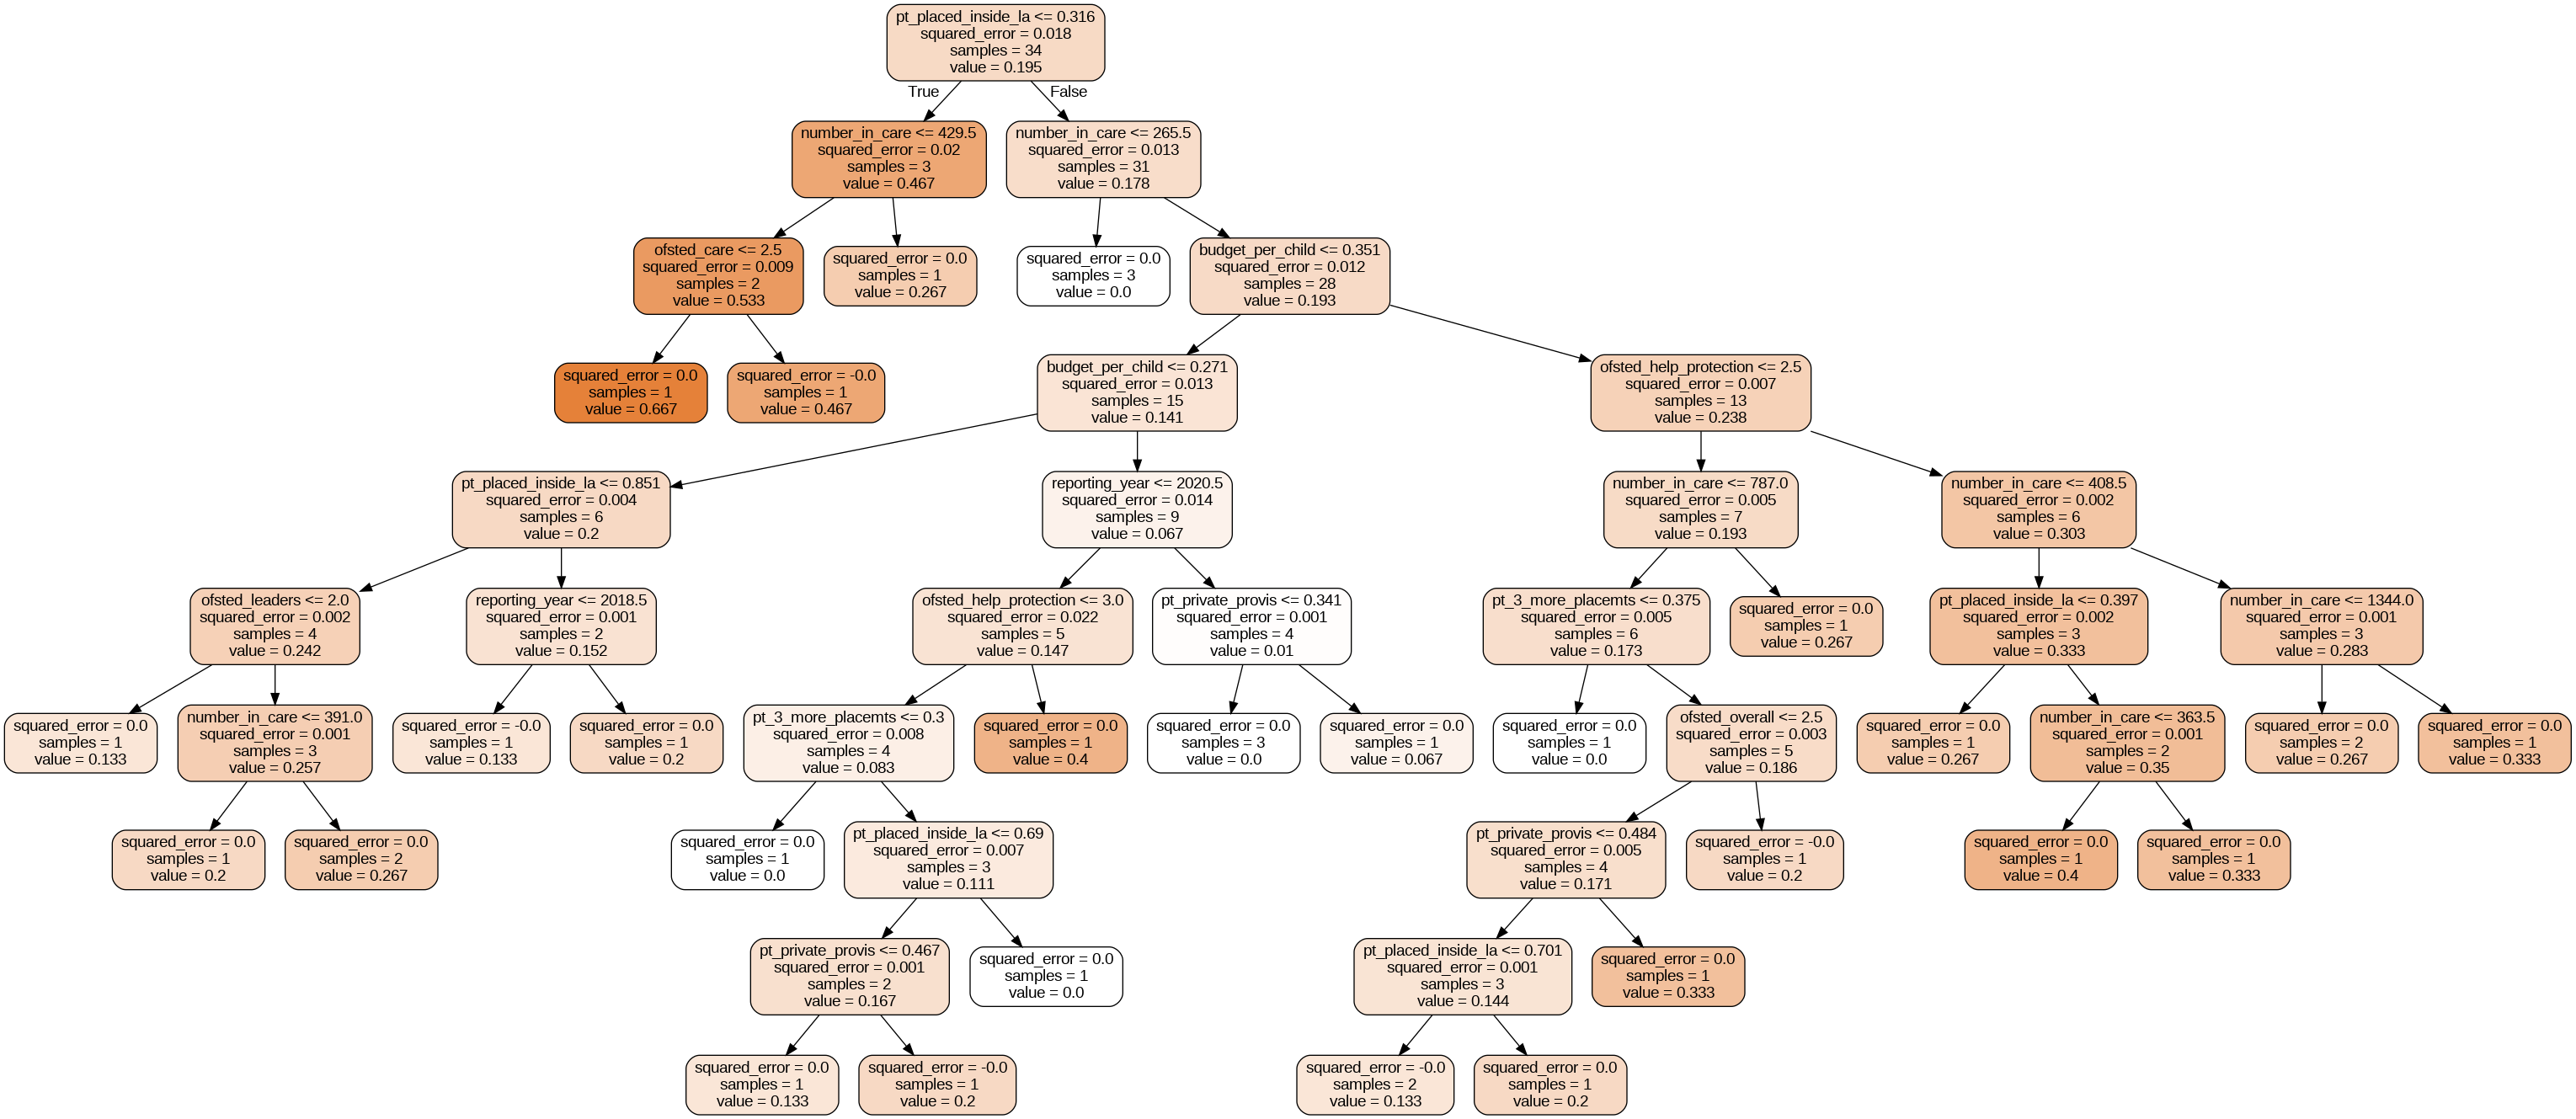

In [ ]:
from sklearn.tree import export_graphviz
import graphviz
from IPython.display import Image

# Assuming reg1 is your GridSearchCV object and X_train, y_train are your training data
dot_data = export_graphviz(reg1.best_estimator_.estimators_[0], out_file=None,
                           filled=True, rounded=True, feature_names=input_features)

# Generate the graph
graph = graphviz.Source(dot_data, format='png')
graph.render('decision_tree_default', view=False)  # Save as PNG

# Display the image
Image(filename='decision_tree_default.png')